# Multi-Dataset ImageNet Training with ResNet50 - Modular Version

This notebook demonstrates training ResNet50 on multiple ImageNet variants using a modular approach. The code supports experiments across different datasets for comprehensive analysis.

## Supported Datasets:
- **ImageNette**: 10 classes, 224x224 images (fastest for experiments)
- **Tiny ImageNet**: 200 classes, 64x64 images (medium complexity)
- **ImageNet Mini**: 1000 classes, 224x224 images (subset of full ImageNet)
- **Full ImageNet**: 1000 classes, 224x224 images (full dataset)

## Features:
- **Modular Design**: Separate modules for configuration, data loading, models, and training utilities
- **Multi-Dataset Support**: Easy switching between different ImageNet variants
- **Dataset-Specific Training**: Optimized hyperparameters for each dataset
- **Comprehensive Metrics**: Tracks training and validation metrics
- **Model Saving**: Automatic model checkpointing with dataset-specific naming


In [ ]:
# Install required packages
%pip install torchsummary albumentations


In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# Import our modular components
from config import Config
from dataset_loader import get_data_loaders, visualize_samples
from models import get_model, count_parameters, get_model_summary, save_model
from training_utils import train_model, evaluate_model, MetricsTracker

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


## Configuration

Let's configure our training parameters. You can easily switch between datasets and modify training parameters here.


In [ ]:
# Configuration setup for multi-dataset experiments
# You can easily switch between datasets by changing DATASET_NAME

# Dataset configuration
DATASET_NAME = "imagenette"  # Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
USE_PRETRAINED = False  # Custom implementation without pretrained weights

# Update configuration for the selected dataset
Config.update_for_dataset(DATASET_NAME)

print("Configuration updated!")
print(f"Dataset: {DATASET_NAME}")
print(f"Image size: {Config.IMAGE_SIZE}")
print(f"Number of classes: {Config.NUM_CLASSES}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Use pretrained: {USE_PRETRAINED}")

# Display dataset-specific training parameters
dataset_config = Config.get_dataset_config()
print(f"\nDataset-specific parameters:")
print(f"Optimizer: {dataset_config['optimizer']}")
print(f"Scheduler: {dataset_config['scheduler']}")


## Environment Setup

Setup the environment and check GPU availability. For full ImageNet training, you'll need significant computational resources.


In [ ]:
# Setup environment
def setup_environment():
    """Setup environment for ImageNet training"""
    print("Setting up environment for ImageNet training...")
    
    # Create necessary directories
    os.makedirs(Config.DATA_ROOT, exist_ok=True)
    os.makedirs(Config.SAVE_MODEL_PATH, exist_ok=True)
    
    print("Environment setup complete!")

def check_gpu_availability():
    """Check GPU availability and setup device"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print("Warning: Full ImageNet training requires significant GPU memory!")
    else:
        print("Warning: CPU training will be very slow for ImageNet!")
    
    return device

# Run setup
setup_environment()
device = check_gpu_availability()

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


## Data Loading

Load the dataset and visualize some sample images.


In [ ]:
# Load dataset
print("Loading dataset...")
train_loader, test_loader = get_data_loaders(DATASET_NAME)

# Visualize some samples
print("\nVisualizing sample images...")
visualize_samples(train_loader, num_samples=12)


## Model Creation

Create the ResNet50 model and display its architecture.


In [ ]:
# Create model
print(f"Creating {Config.MODEL_NAME} model...")
model = get_model(
    model_name=Config.MODEL_NAME,
    dataset_name=DATASET_NAME,
    pretrained=USE_PRETRAINED
)

# Move model to device
model = model.to(device)

# Print model info
print(f"Model parameters: {count_parameters(model):,}")

# Get model summary
dataset_config = Config.get_dataset_config()
input_size = (3, dataset_config["image_size"], dataset_config["image_size"])
print(f"\nModel summary (input size: {input_size}):")
get_model_summary(model, input_size=input_size)


## Training

Train the model using our modular training utilities.


In [ ]:
# Train model
print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")

metrics_tracker = train_model(model, train_loader, test_loader, device, Config)


## Results Visualization

Plot the training metrics and evaluate the final model.


In [ ]:
# Plot training metrics
print("Plotting training metrics...")
metrics_tracker.plot_metrics(save_path=f"{Config.SAVE_MODEL_PATH}/training_metrics.png")

# Final evaluation
print("\nFinal evaluation...")
test_loss, test_acc, test_top5_acc = evaluate_model(model, test_loader, device)

print(f"\nTraining completed!")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Top-5 Accuracy: {test_top5_acc:.2f}%")


## Model Saving

Save the trained model to local storage and Google Drive.


In [ ]:
# Save final model
final_model_path = f"{Config.SAVE_MODEL_PATH}/final_model.pth"
save_model(model, final_model_path, epoch=NUM_EPOCHS, loss=test_loss)

# Save to Google Drive if mounted
if Config.MOUNT_DRIVE:
    drive_model_path = f"{Config.DRIVE_MODEL_PATH}/final_model.pth"
    save_model(model, drive_model_path, epoch=NUM_EPOCHS, loss=test_loss)
    print(f"Model also saved to Google Drive: {drive_model_path}")

print("Model saving completed!")


## Multi-Dataset Experiments

You can easily switch between different datasets for experiments. Each dataset has optimized hyperparameters.


In [ ]:
# Multi-dataset experiment examples
# Uncomment the dataset you want to experiment with

# Example 1: ImageNette (fastest, 10 classes)
# DATASET_NAME = "imagenette"
# Config.update_for_dataset(DATASET_NAME)

# Example 2: Tiny ImageNet (medium complexity, 200 classes)
# DATASET_NAME = "tiny_imagenet"
# Config.update_for_dataset(DATASET_NAME)

# Example 3: ImageNet Mini (1000 classes subset)
# DATASET_NAME = "imagenet_mini"
# Config.update_for_dataset(DATASET_NAME)

# Example 4: Full ImageNet (1000 classes, full dataset)
# DATASET_NAME = "imagenet"
# Config.update_for_dataset(DATASET_NAME)

print("To experiment with different datasets:")
print("1. Uncomment the dataset you want to use")
print("2. Run this cell to update configuration")
print("3. Continue with the rest of the notebook")
print("\nDataset comparison:")
print("- ImageNette: ~13k images, 10 classes, ~30 epochs")
print("- Tiny ImageNet: ~100k images, 200 classes, ~50 epochs")
print("- ImageNet Mini: ~100k images, 1000 classes, ~50 epochs")
print("- Full ImageNet: ~1.2M images, 1000 classes, ~90 epochs")




# Tiny ImageNet with Resnet50

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

**Compute Mean and Standard Deviation for Normalization of data**. Commented as it is needed only once

In [ ]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def get_mean_and_std(dataloader):
#     """
#     Calculate the mean and standard deviation of a dataset.

#     Args:
#         dataloader (DataLoader): The DataLoader for the dataset.

#     Returns:
#         tuple: The mean and standard deviation tensors for each channel.
#     """
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader, desc="Calculating mean and std"):
#         # Mean over batch, height, and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     # Std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     return mean, std

# # 1. Load the dataset without normalization (only convert to tensor)
# # This will automatically download the dataset if it's not present
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# # 2. Create a DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# # 3. Get the mean and standard deviation
# mean, std = get_mean_and_std(train_loader)

# print('Calculated Mean:', mean)
# print('Calculated Standard Deviation:', std)

# 100%|██████████| 169M/169M [00:06<00:00, 27.9MB/s]
# Calculating mean and std: 100%|██████████| 391/391 [00:07<00:00, 50.50it/s]
# Calculated Mean: tensor([0.5070, 0.4865, 0.4409])
# Calculated Standard Deviation: tensor([0.2673, 0.2564, 0.2761])

In [ ]:
# Train Phase transformations
# Define your Albumentations pipeline
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

CIFAR_MEAN = (0.5070, 0.4865, 0.4409)
CIFAR_STD  = (0.2673, 0.2564, 0.2761)


train_alb = A.Compose([
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
    A.RandomCrop(32, 32, p=1.0),  # Then crop
    A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.OneOf([
        A.CoarseDropout(
            max_holes=1,
            max_height=16,
            max_width=16,
            min_height=8,
            min_width=8,
            fill_value=tuple([int(x * 255) for x in [0.5071, 0.4867, 0.4408]]),
            p=0.75
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),
    ], p=0.5),
    A.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ToTensorV2(),
])

# test: only normalize + tensor
test_alb = A.Compose([
    A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
    ToTensorV2(),
])

# wrapper functions for torchvision CIFAR100 dataset
def alb_train_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return train_alb(image=img)["image"]

def alb_test_transform(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    return test_alb(image=img)["image"]



/tmp/ipython-input-1334562076.py:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),  # Pad first
/tmp/ipython-input-1334562076.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipython-input-1334562076.py:26: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


In [ ]:
train = datasets.CIFAR100('./data', train=True, download=True, transform=alb_train_transform)
test = datasets.CIFAR100('./data', train=False, download=True, transform=alb_test_transform)

100%|██████████| 169M/169M [00:04<00:00, 39.9MB/s]


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


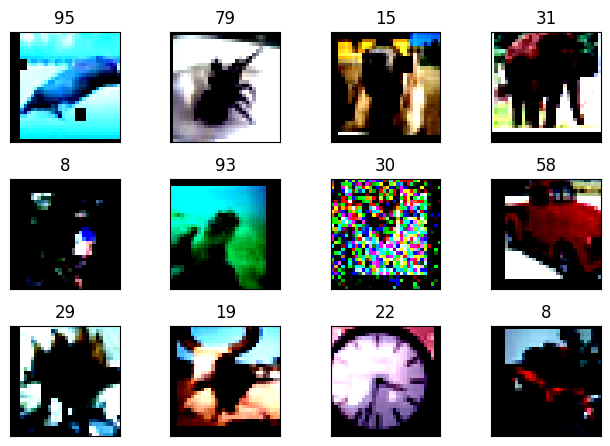

In [ ]:

import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(batch_data[i].permute(1,2,0))

  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from tqdm import tqdm


# Bottleneck block (same as before)
class Bottleneck(nn.Module):
 expansion = 4

 def __init__(self, in_channels, out_channels, stride=1, downsample=None):
  super(Bottleneck, self).__init__()
  self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
  self.bn1 = nn.BatchNorm2d(out_channels)

  self.conv2 = nn.Conv2d(
   out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
  )
  self.bn2 = nn.BatchNorm2d(out_channels)

  self.conv3 = nn.Conv2d(
   out_channels, out_channels * self.expansion, kernel_size=1, bias=False
  )
  self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

  self.relu = nn.ReLU(inplace=True)
  self.downsample = downsample

 def forward(self, x):
  identity = x

  out = self.conv1(x)
  out = self.bn1(out)
  out = self.relu(out)

  out = self.conv2(out)
  out = self.bn2(out)
  out = self.relu(out)

  out = self.conv3(out)
  out = self.bn3(out)

  if self.downsample is not None:
   identity = self.downsample(x)

  out += identity
  out = self.relu(out)
  return out


# ResNet tailored for CIFAR (no initial 7x7 stride-2 conv + no maxpool)
class ResNetCIFAR(nn.Module):
 def __init__(self, block, layers, num_classes=100):
  super(ResNetCIFAR, self).__init__()
  self.in_channels = 64

  # Adjusted first conv for CIFAR (3x3, stride=1)
  self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
  self.bn1 = nn.BatchNorm2d(64)
  self.relu = nn.ReLU(inplace=True)

  # NOTE: we do NOT use the 7x7 stride-2 conv or the 3x3 maxpool used for ImageNet
  # Stage layers
  self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
  self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
  self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
  self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

  self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
  self.fc = nn.Linear(512 * block.expansion, num_classes)

  # Weight initialization
  for m in self.modules():
   if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
   elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)

 def _make_layer(self, block, out_channels, blocks, stride=1):
  downsample = None
  if stride != 1 or self.in_channels != out_channels * block.expansion:
   downsample = nn.Sequential(
    nn.Conv2d(
     self.in_channels,
     out_channels * block.expansion,
     kernel_size=1,
     stride=stride,
     bias=False,
    ),
    nn.BatchNorm2d(out_channels * block.expansion),
   )

  layers = []
  layers.append(block(self.in_channels, out_channels, stride, downsample))
  self.in_channels = out_channels * block.expansion
  for _ in range(1, blocks):
   layers.append(block(self.in_channels, out_channels))

  return nn.Sequential(*layers)

 def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  # no maxpool

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  x = self.avgpool(x)
  x = torch.flatten(x, 1)
  x = self.fc(x)
  return x


def resnet50_cifar(num_classes=100):
 return ResNetCIFAR(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet50_cifar().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1,

In [ ]:
import torch

def topk_accuracy(output, target, k=5):
    """
    Calculates the top-k accuracy for a given output and target.

    Args:
        output (torch.Tensor): The model's raw output logits, typically from the last layer.
        target (torch.Tensor): The ground-truth labels.
        k (int): The number of top predictions to consider.

    Returns:
        float: The top-k accuracy.
    """
    with torch.no_grad():
        # Get the top k predictions
        _, topk_preds = output.topk(k, dim=1, largest=True, sorted=True)

        # Reshape the target tensor for comparison
        target_reshaped = target.view(1, -1).expand_as(topk_preds)

        # Check if any of the top k predictions match the true label
        correct = (topk_preds == target_reshaped)

        # Calculate the number of correct predictions
        correct_count = correct.any(dim=0).sum().item()

        # Return the accuracy as a percentage
        return (correct_count / target.size(0))


In [ ]:

# Learnings:
# Weight decay was added in Adam for Regularization but it didnt help much and accuracy was stuck around 65
# Switched to AdamW improved the accuracy.
# Tried Cosine Annealing but it seems that 50 epcohs was not the right window
#  Cosine Annealing uses a predefined curve so switched to ReduceLROnPlateau to make it adaptive.
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # minimize validation loss
    factor=0.5,        # reduce LR by a factor of 0.75
    patience=3,        # wait 3 epochs with no improvement
    threshold=1e-3,    # minimum change to qualify as improvement
    min_lr=1e-4,       # do not reduce below this LR
)


In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_top5_acc = [] # New list to store top-5 accuracy

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.cross_entropy(y_pred, target,label_smoothing=0.1)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
# Update the learning rate After each batch if doing OnecycleLR else after each epoch
# scheduler.step() # Moved scheduler.step() to the training loop after test()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct_top1 = 0
    correct_top5 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # Top-1 accuracy calculation
            pred_top1 = output.argmax(dim=1, keepdim=True)
            correct_top1 += pred_top1.eq(target.view_as(pred_top1)).sum().item()

            # Top-5 accuracy calculation
            # correct_top5 += topk_accuracy(output, target, k=5)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    top1_acc = 100. * correct_top1 / len(test_loader.dataset)
    # top5_acc = 100. * correct_top5 / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f} ,Top-1 Accuracy: {correct_top1}/{len(test_loader.dataset)} ({top1_acc:.2f}%)%\n')

    test_acc.append(top1_acc)
    # test_top5_acc.append(top5_acc)
    return test_loss

In [ ]:
# !pip install torch-lr-finder


In [ ]:
# import torch
# from torch import nn, optim
# from torch_lr_finder import LRFinder
# import matplotlib.pyplot as plt

# # 3. Instantiate model, optimizer, and criterion
# device = "cuda" if torch.cuda.is_available() else "cpu"
# # Assuming 'model' is already defined and on the correct device
# # e.g., model = resnet34_cifar().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-7)  # Start with a very small LR
# criterion = nn.CrossEntropyLoss()

# # 4. Run the LR finder
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=0.1, num_iter=300)
# # 5. Plot the results
# lr_finder.plot()

# # 6. Reset the model and optimizer to their initial states
# lr_finder.reset()
# #>>>>>>>>4.32e-03 for batch size 128,
# # LR: 9.05E-03 for batch size 256
# ##Suggested LR: 7.88E-03 for  batch size 512


In [ ]:
torch.autograd.set_detect_anomaly(True)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step(test_loss) # Pass test_loss to the scheduler

EPOCH: 1


Loss=3.869758129119873 Batch_id=195 Accuracy=7.47: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 3.8226 ,Top-1 Accuracy: 1278/10000 (12.78%)%

EPOCH: 2


Loss=3.635023832321167 Batch_id=195 Accuracy=16.71: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 3.2060 ,Top-1 Accuracy: 2102/10000 (21.02%)%

EPOCH: 3


Loss=3.32423996925354 Batch_id=195 Accuracy=24.83: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 2.8436 ,Top-1 Accuracy: 2791/10000 (27.91%)%

EPOCH: 4


Loss=2.894665479660034 Batch_id=195 Accuracy=32.11: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 2.5371 ,Top-1 Accuracy: 3427/10000 (34.27%)%

EPOCH: 5


Loss=2.6400256156921387 Batch_id=195 Accuracy=38.02: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 2.3055 ,Top-1 Accuracy: 3994/10000 (39.94%)%

EPOCH: 6


Loss=2.5170180797576904 Batch_id=195 Accuracy=43.46: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 2.0368 ,Top-1 Accuracy: 4539/10000 (45.39%)%

EPOCH: 7


Loss=2.4625425338745117 Batch_id=195 Accuracy=47.25: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 1.9502 ,Top-1 Accuracy: 4757/10000 (47.57%)%

EPOCH: 8


Loss=2.2403564453125 Batch_id=195 Accuracy=51.44: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 4.8463 ,Top-1 Accuracy: 3889/10000 (38.89%)%

EPOCH: 9


Loss=2.1723709106445312 Batch_id=195 Accuracy=54.00: 100%|██████████| 196/196 [01:33<00:00,  2.10it/s]



Test set: Average loss: 1.6968 ,Top-1 Accuracy: 5376/10000 (53.76%)%

EPOCH: 10


Loss=2.1376733779907227 Batch_id=195 Accuracy=56.92: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.6019 ,Top-1 Accuracy: 5649/10000 (56.49%)%

EPOCH: 11


Loss=1.9623136520385742 Batch_id=195 Accuracy=60.00: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.5650 ,Top-1 Accuracy: 5798/10000 (57.98%)%

EPOCH: 12


Loss=1.9615793228149414 Batch_id=195 Accuracy=61.72: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.4646 ,Top-1 Accuracy: 6009/10000 (60.09%)%

EPOCH: 13


Loss=1.94589102268219 Batch_id=195 Accuracy=63.79: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.5265 ,Top-1 Accuracy: 5949/10000 (59.49%)%

EPOCH: 14


Loss=1.9459686279296875 Batch_id=195 Accuracy=64.67: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 5.7199 ,Top-1 Accuracy: 4736/10000 (47.36%)%

EPOCH: 15


Loss=1.9373314380645752 Batch_id=195 Accuracy=66.59: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.4132 ,Top-1 Accuracy: 6220/10000 (62.20%)%

EPOCH: 16


Loss=2.0476608276367188 Batch_id=195 Accuracy=68.57: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.4181 ,Top-1 Accuracy: 6244/10000 (62.44%)%

EPOCH: 17


Loss=1.688154935836792 Batch_id=195 Accuracy=70.23: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.3082 ,Top-1 Accuracy: 6472/10000 (64.72%)%

EPOCH: 18


Loss=1.510732650756836 Batch_id=195 Accuracy=71.43: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.3150 ,Top-1 Accuracy: 6466/10000 (64.66%)%

EPOCH: 19


Loss=1.6763197183609009 Batch_id=195 Accuracy=72.75: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.2663 ,Top-1 Accuracy: 6512/10000 (65.12%)%

EPOCH: 20


Loss=1.612204670906067 Batch_id=195 Accuracy=74.13: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.2844 ,Top-1 Accuracy: 6514/10000 (65.14%)%

EPOCH: 21


Loss=1.557685136795044 Batch_id=195 Accuracy=75.57: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.4036 ,Top-1 Accuracy: 6414/10000 (64.14%)%

EPOCH: 22


Loss=1.6112279891967773 Batch_id=195 Accuracy=74.40: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.2777 ,Top-1 Accuracy: 6634/10000 (66.34%)%

EPOCH: 23


Loss=1.600617527961731 Batch_id=195 Accuracy=76.41: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.2556 ,Top-1 Accuracy: 6670/10000 (66.70%)%

EPOCH: 24


Loss=1.4813865423202515 Batch_id=195 Accuracy=78.80: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.2145 ,Top-1 Accuracy: 6749/10000 (67.49%)%

EPOCH: 25


Loss=1.4409700632095337 Batch_id=195 Accuracy=80.15: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]



Test set: Average loss: 1.2638 ,Top-1 Accuracy: 6727/10000 (67.27%)%

EPOCH: 26


Loss=1.3914510011672974 Batch_id=195 Accuracy=80.89: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]



Test set: Average loss: 1.1936 ,Top-1 Accuracy: 6885/10000 (68.85%)%

EPOCH: 27


Loss=1.1919128894805908 Batch_id=195 Accuracy=81.84: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2262 ,Top-1 Accuracy: 6795/10000 (67.95%)%

EPOCH: 28


Loss=1.3154962062835693 Batch_id=195 Accuracy=83.19: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2124 ,Top-1 Accuracy: 6913/10000 (69.13%)%

EPOCH: 29


Loss=1.3670666217803955 Batch_id=195 Accuracy=83.84: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2626 ,Top-1 Accuracy: 6799/10000 (67.99%)%

EPOCH: 30


Loss=1.3260791301727295 Batch_id=195 Accuracy=84.01: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.2024 ,Top-1 Accuracy: 6922/10000 (69.22%)%

EPOCH: 31


Loss=1.0704212188720703 Batch_id=195 Accuracy=88.74: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0906 ,Top-1 Accuracy: 7215/10000 (72.15%)%

EPOCH: 32


Loss=1.0833816528320312 Batch_id=195 Accuracy=89.99: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0997 ,Top-1 Accuracy: 7252/10000 (72.52%)%

EPOCH: 33


Loss=1.00822114944458 Batch_id=195 Accuracy=90.52: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]



Test set: Average loss: 1.1272 ,Top-1 Accuracy: 7217/10000 (72.17%)%

EPOCH: 34


Loss=1.045372486114502 Batch_id=195 Accuracy=91.14: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1053 ,Top-1 Accuracy: 7295/10000 (72.95%)%

EPOCH: 35


Loss=1.0840001106262207 Batch_id=195 Accuracy=91.27: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1400 ,Top-1 Accuracy: 7217/10000 (72.17%)%

EPOCH: 36


Loss=1.0881147384643555 Batch_id=195 Accuracy=92.38: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0797 ,Top-1 Accuracy: 7342/10000 (73.42%)%

EPOCH: 37


Loss=0.987473726272583 Batch_id=195 Accuracy=92.79: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0832 ,Top-1 Accuracy: 7377/10000 (73.77%)%

EPOCH: 38


Loss=0.9902850985527039 Batch_id=195 Accuracy=93.05: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0965 ,Top-1 Accuracy: 7395/10000 (73.95%)%

EPOCH: 39


Loss=1.0126115083694458 Batch_id=195 Accuracy=93.16: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1034 ,Top-1 Accuracy: 7344/10000 (73.44%)%

EPOCH: 40


Loss=1.0198535919189453 Batch_id=195 Accuracy=93.30: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1082 ,Top-1 Accuracy: 7345/10000 (73.45%)%

EPOCH: 41


Loss=0.9365944266319275 Batch_id=195 Accuracy=93.69: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.0980 ,Top-1 Accuracy: 7395/10000 (73.95%)%

EPOCH: 42


Loss=0.9793956279754639 Batch_id=195 Accuracy=93.93: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]



Test set: Average loss: 1.1016 ,Top-1 Accuracy: 7379/10000 (73.79%)%

EPOCH: 43


Loss=0.9550695419311523 Batch_id=195 Accuracy=94.02: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1149 ,Top-1 Accuracy: 7371/10000 (73.71%)%

EPOCH: 44


Loss=0.9819129705429077 Batch_id=195 Accuracy=93.93: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1141 ,Top-1 Accuracy: 7398/10000 (73.98%)%

EPOCH: 45


Loss=1.0116387605667114 Batch_id=195 Accuracy=94.09: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1086 ,Top-1 Accuracy: 7412/10000 (74.12%)%

EPOCH: 46


Loss=0.9274983406066895 Batch_id=195 Accuracy=93.91: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1167 ,Top-1 Accuracy: 7389/10000 (73.89%)%

EPOCH: 47


Loss=0.9243737459182739 Batch_id=195 Accuracy=94.25: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1177 ,Top-1 Accuracy: 7384/10000 (73.84%)%

EPOCH: 48


Loss=0.9691476225852966 Batch_id=195 Accuracy=94.39: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1245 ,Top-1 Accuracy: 7409/10000 (74.09%)%

EPOCH: 49


Loss=0.8690693974494934 Batch_id=195 Accuracy=94.24: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]



Test set: Average loss: 1.1152 ,Top-1 Accuracy: 7406/10000 (74.06%)%

EPOCH: 50


Loss=0.9070953726768494 Batch_id=195 Accuracy=94.41: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]



Test set: Average loss: 1.1202 ,Top-1 Accuracy: 7408/10000 (74.08%)%



Text(0.5, 1.0, 'Test Accuracy')

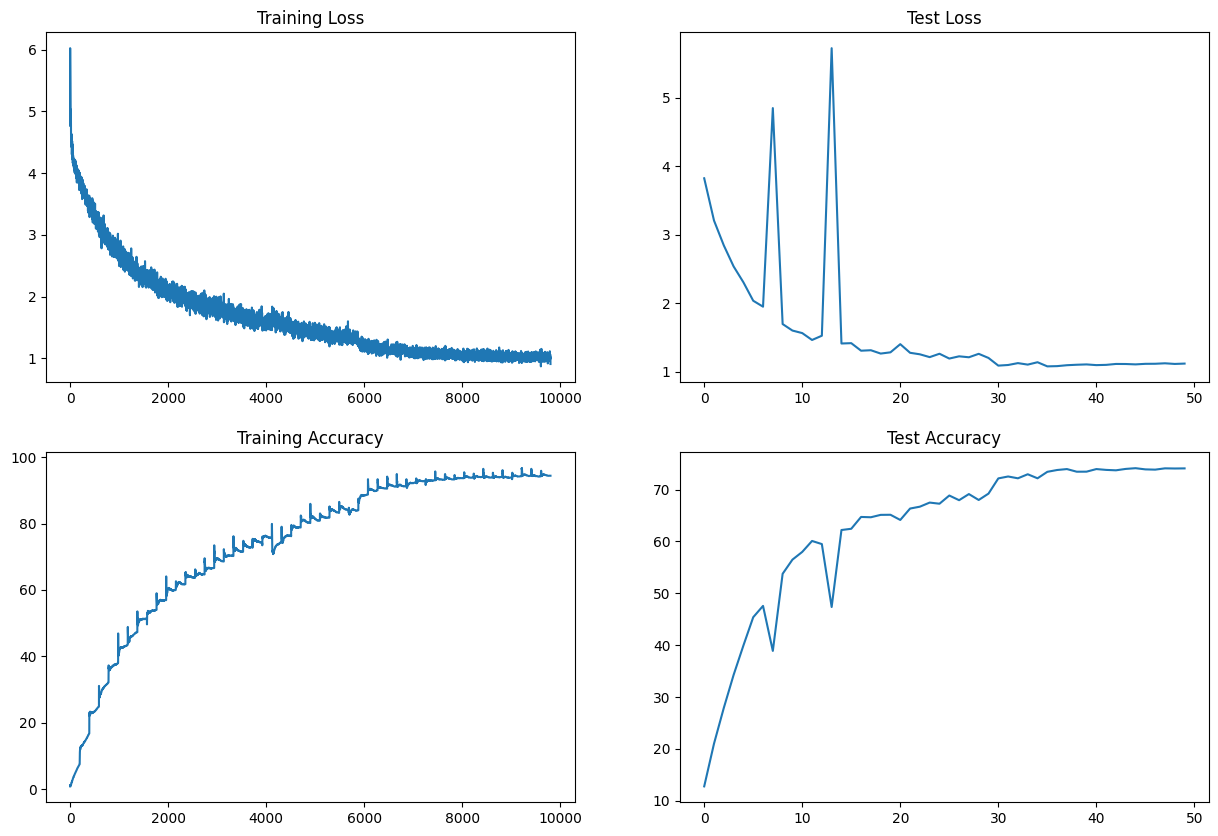

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
from google.colab import drive
import torch

drive.mount('/gdrive')
# Save the model's state dictionary
torch.save(model.state_dict(), '/gdrive/My Drive/CIFAR100onResnet50v3.pth')
print("Model saved to /gdrive/My Drive/CIFAR100onResnet50v3.pth")

Mounted at /gdrive
Model saved to /gdrive/My Drive/CIFAR100onResnet50v3.pth
